In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Using TensorFlow backend.


Dans un premier temps on définit les adresses des images et du model pour stardist

In [2]:
brigthfield_path = '../../../assets/sample_image_actin_surligned.tif'
dapi_path = '../../../assets/sample_image_dapi.tiff'
scp_path = '../../../assets/star_convex_polynoms/models'

### Extraction du maillage

La fonction generate_ring_from_image segmente les noyaux pour déterminer la position des centres des cellules et extrait les membranes apicales et basales de l'organoïde. Après l'avoir appelée, il est nécéssaire d'initialiser les données de l'organoïde obtenu avec des tensions, des aires et une adhésion basale.

La fonction generate_ring_from_image prend comme paramètres :

- brigthfield_path : le chemin vers l'image brightfield
- dapi_path: le chemin vers l'image DAPI (marquage des noyaux)
- scp_model_path: le chemin vers le model stardist
- threshold: la valeur du threshold utilisé pour l'extraction des membranes
- blur: la valeur du flou gaussien appliqué pour l'extraction des membranes
- rol_window_inside: la largeur de la fenêtre pour la moyenne mobile sur le contour apical
- rol_window_outside: la largeur de la fenêtre pour la moyenne mobile sur le contour basal

Remarque : l'extraction des membranes n'est pas robuste et est très sensible au paramètre du threshold. Pour l'image utilisée dans ce notebook, qui est une version de l'image brightfield avec les membranes repassées à la main, la valeur du threshold donnant les meilleurs résultat est 2. Cette valeur peu beaucoup varier si l'on change d'image. Par exemple, il faut la fixer à 28 si on utilise l'image brightfield non modifiée. 

In [3]:
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           blur=9,
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)

Loading network weights from 'weights_best.h5'.


In [4]:
geom.update_all(organo)
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  organo.face_df.area.values, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm':  organo.vert_df.x.values,
        'y_ecm':  organo.vert_df.y.values,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)

Reseting datasets values with new specs


Enfin, on appel normalize_scale pour que le maillage ai une taille standard. La fonction normalize_scale prend en paramètres:

- organo: un maillage de class AnnularSheet
- geom : tyssue geometry class
- refer (optionnel): defaut = 'area'. Si 'area', les coordonnées sont modifiées pour que l'aire moyenne des cellules soit 1. Si 'edges' les coordonnées sont modifiées pour que la longueur moyenne des segments sont égale à 1. En général je n'ai utilisé que 'areas'.


In [5]:
normalize_scale(organo, geom)
geom.update_all(organo)

On peut à présent manipuler le maillage.

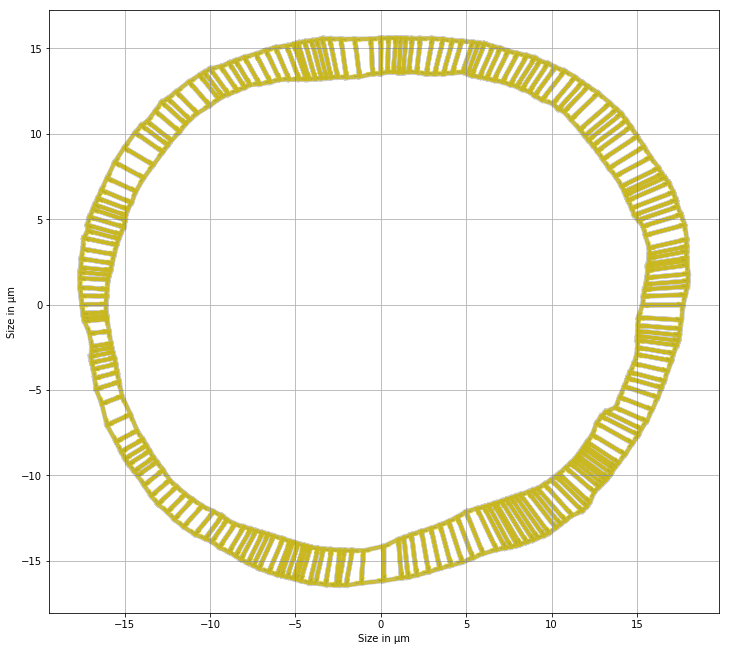

In [6]:
print_tensions(organo, organo)